<font size = 6> Credit Card Customer Churn (unsupervised)<font> <br>

<font size = 5> **About Data** <font>

In this project we will be classifying credit card customer data for churn behavior using Kmeans Clustering on the data below:


A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

Here is the link to the dataset in Kaggle:

https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

Now, this dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.

<font size = 5> **Load Packages** <font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\minaa\AppData\Local\Temp\ipykernel_15912\555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<font size = 5> **Read Data** <font>

In [13]:
df = pd.read_csv("BankChurners.csv")

#data size
print(df.shape)

df.head()

(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [14]:
#feature types
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

first column is client id and two last columns are for naive bayes model so we can eliminate them.

In [35]:
#remove 1st, and two last columns
df.drop(df.columns[[0, 21, 22]], axis = 1, inplace = True)

In [44]:
df.select_dtypes(["object"])

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue
3,Existing Customer,F,High School,Unknown,Less than $40K,Blue
4,Existing Customer,M,Uneducated,Married,$60K - $80K,Blue
...,...,...,...,...,...,...
10122,Existing Customer,M,Graduate,Single,$40K - $60K,Blue
10123,Attrited Customer,M,Unknown,Divorced,$40K - $60K,Blue
10124,Attrited Customer,F,High School,Married,Less than $40K,Blue
10125,Attrited Customer,M,Graduate,Unknown,$40K - $60K,Blue


In [53]:
#define a function to show the unique values of a column
def unique_values(df):
    dict = {}
    categorical_cols = df.select_dtypes(["object"]).columns
    for col in categorical_cols:
        dict[col] = df[col].unique()
    return dict


unique_values(df)

{'Attrition_Flag': array(['Existing Customer', 'Attrited Customer'], dtype=object),
 'Gender': array(['M', 'F'], dtype=object),
 'Education_Level': array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
        'Post-Graduate', 'Doctorate'], dtype=object),
 'Marital_Status': array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object),
 'Income_Category': array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
        '$120K +', 'Unknown'], dtype=object),
 'Card_Category': array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)}

**Note:** <br>
We see that there are some unknown categories for columns Education_Level, Martial_Status and Income_Category. Let's check them out.

In [66]:
print(df[df["Income_Category"] == "Unknown"].shape[0])
print(df[df["Marital_Status"] == "Unknown"].shape[0])
print(df[df["Education_Level"] == "Unknown"].shape[0])

1112
749
1519


In [94]:
#define a function to replace unknown values with the majority category of each column
def missing_value_filler(column):
    majority_category = column.mode()[0]
    column = column.replace("Unknown", majority_category)
    return column

#Apply function on the columns with missing values
missing_columns = ["Income_Category", "Marital_Status", "Education_Level"]
df[missing_columns] = df[missing_columns].apply(missing_value_filler, axis = 0)

<font size = 5> **Any null values?** <font>

In [105]:
df.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

<font size = 5> **Data Visualization** <font>

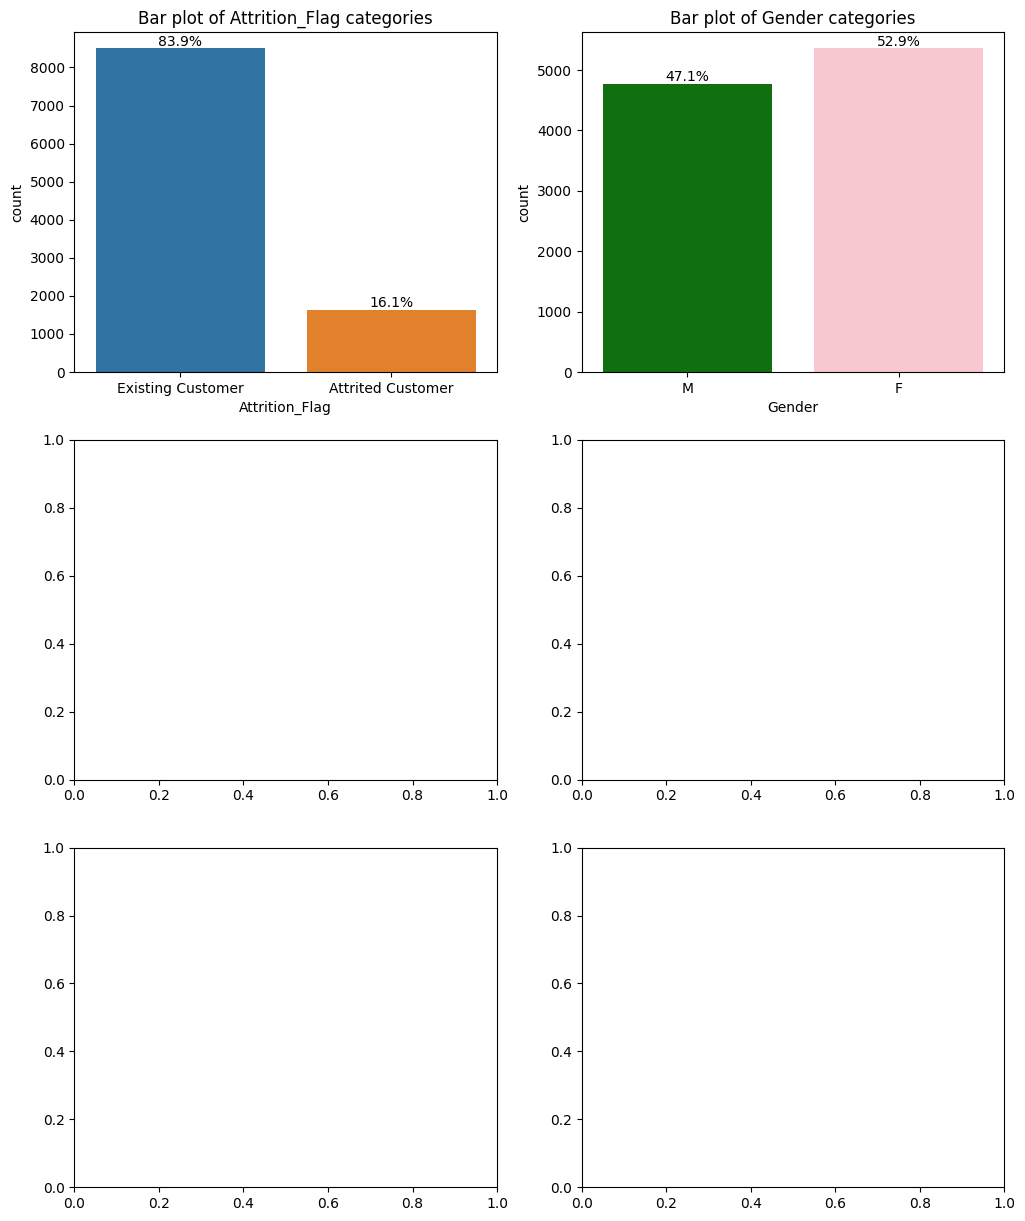

In [129]:
fig, axes = plt.subplots(3, 2, figsize = (12, 15))


#Attrition_Flag Plot
sns.countplot(x = "Attrition_Flag", data = df, 
              hue = "Attrition_Flag",
              ax = axes[0, 0])
axes[0, 0].set_title("Bar plot of Attrition_Flag categories")

counts = df['Attrition_Flag'].value_counts()
total = len(df)
percentages = counts / total * 100

# Add percentage labels to each bar
for p in axes[0, 0].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[0, 0].text(x, y, percentage, ha='center', va='bottom')


#Gender Plot
sns.countplot(x = "Gender", data = df,
              hue = "Gender", palette = ["green", "pink"],
              ax = axes[0, 1])
axes[0, 1].set_title("Bar plot of Gender categories")


counts = df['Gender'].value_counts()
total = len(df)
percentages = counts / total * 100

# Add percentage labels to each bar
for p in axes[0, 1].patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x() + width / 2
    y = height
    percentage = f'{height / total * 100:.1f}%'
    axes[0, 1].text(x, y, percentage, ha='center', va='bottom')